# Variational Auto Encoder
An implementation of Variational Auto Encoder done to understand paper [Kingma, Diederik P and Max Welling (2013).Auto-Encoding Variational Bayes.] with some help of [Doersch, Carl (2016).Tutorial on Variational Autoencoders.]

In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from tqdm.notebook import tqdm, trange


class Encoder(nn.Module):
    """
    Responsible for generating from q(z|x) distribution: gaussian with diagonal covariance matrix
    with parameters (both means and standard deviations) given by multilayer perceptron.
    """
    def __init__(self, n_in, dim):
        super().__init__()
        self.mean = None
        self.sd = None
        hidden_dim = 256
        self.encode = nn.Sequential(
            nn.Linear(n_in, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.encode_mean = nn.Linear(hidden_dim, dim)
        self.encode_sd = nn.Sequential(
            nn.Linear(hidden_dim, dim),
            nn.ReLU()
        )

    def forward(self, x):
        z = self.encode(x)
        self.mean = self.encode_mean(z)
        self.sd = self.encode_sd(z) + 0.00001
        assert self.mean.shape == self.sd.shape
        return self.mean + self.sd * torch.randn_like(self.sd)
    
    def deterministic_forward(self, x):
        z = self.encode(x)
        return self.encode_mean(z)


class Decoder(nn.Module):
    def __init__(self, dim, n_out):
        super().__init__()
        self.a = nn.Parameter(torch.tensor([0.001]).float(), requires_grad=True)
        self.b = nn.Parameter(torch.tensor([0.]).float(), requires_grad=True)
        # self.ro = nn.Parameter(torch.tensor([0]), requires_grad=True)
#         self.sigma_1 = nn.Parameter(torch.tensor([0]), requires_grad=True)
#         self.sigma_2 = nn.Parameter(torch.tensor([0]), requires_grad=True)

    def forward(self, z):
        x1 = z
        x2 = self.a * z + self.b
        x = torch.stack([x1, x2], dim=1).view(-1, 2)
        return x

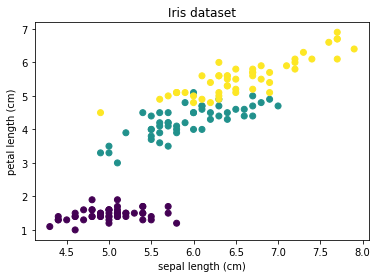

In [18]:
iris = load_iris()
x_np = iris["data"][:, [0, 2]]
y = iris["target"]
plt.scatter(x_np[:, 0], x_np[:, 1], c=y)
plt.xlabel("sepal length (cm)")
plt.ylabel("petal length (cm)")
plt.title("Iris dataset");

In [19]:
x = torch.tensor(x_np).float()

In [20]:
encoder = Encoder(2, 1)
decoder = Decoder(1, 2)

(462.3669738769531, 80.70822143554688, 3816.561279296875)

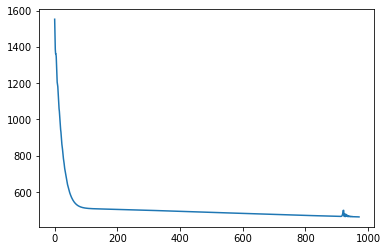

In [31]:
lr = 0.01

x = torch.tensor(x_np).float()

data_dim = 2
hidden_dim = 1

encoder = Encoder(data_dim, hidden_dim)
decoder = Decoder(hidden_dim, data_dim)

mse = nn.MSELoss()
optimizer = optim.Adam((*encoder.parameters(), *decoder.parameters()), lr=lr)

tol = 1e-2
losses = []
while True:
    optimizer.zero_grad()
    z = encoder(x)
    rec = decoder(z)
    rec_loss = torch.sum((x - rec)**2) / 2
    kl_loss = (encoder.sd**2 + (encoder.mean)**2 - 2*torch.log(encoder.sd) - 1).sum() / 2
    loss = rec_loss + 0.1*kl_loss
    if losses and abs(loss.item() - losses[-1]) < tol:
        break
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
plt.plot(losses[10:])
losses[-1], rec_loss.item(), kl_loss.item()

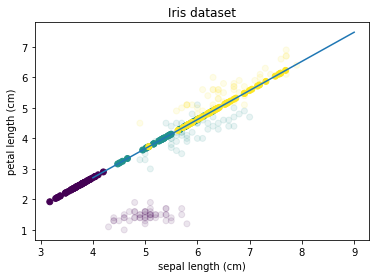

In [33]:
plt.scatter(x_np[:, 0], x_np[:, 1], c=y, alpha=0.1)
x_values = np.linspace(4,9,100)
y_values = decoder.a.item() * x_values + decoder.b.item()
plt.plot(x_values, y_values)

z = encoder.deterministic_forward(x)
x_model = decoder(z).detach().numpy()
plt.scatter(x_model[:, 0], x_model[:, 1], c=y)

plt.xlabel("sepal length (cm)")
plt.ylabel("petal length (cm)")
plt.title("Iris dataset");

# Notes
Now, a couple of observations:
* What to do with $\sigma$ in a distribution $p(x|z)$? We currently use constant $\sigma$, but can we use it also as a parameter in a model ($\sigma^2$ is just a variance of our samples)? In that way, we can make sure we are indeed maximizing true variational lower bound, and not doing some weird tricks for autoencoder. In this case, I put $\sigma$, such that KL loss contribution is smaller (and it doesn't force distribution q to be too small).
* In this scenario, since decoder is extrememly shallow and we are forcing standard normal distribution on $z$, it is difficult to achieve. One of the reasons is that we say $x_1 = z$, but $x_1$ is in a range from $3$ to $9$. Because of that, we cannot really generate new samples by generating from $\mathcal{N}(0, 1)$ and passing it to decoder. It is because decoder is too weak. We can make it work by increasing the complexity of a decoder. We can start with simply making both $z$ coordinates as affine transformations.

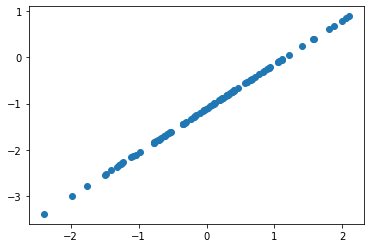

In [36]:
z = torch.randn((100))
x = decoder(z).detach().numpy()
plt.scatter(x[:, 0], x[:, 1])

---
#### Affine decoder

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris


class Encoder(nn.Module):
    """
    Responsible for generating from q(z|x) distribution: gaussian with diagonal covariance matrix
    with parameters (both means and standard deviations) given by multilayer perceptron.
    """
    def __init__(self, n_in, dim):
        super().__init__()
        self.mean = None
        self.sd = None
        hidden_dim = 256
        self.encode = nn.Sequential(
            nn.Linear(n_in, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.encode_mean = nn.Linear(hidden_dim, dim)
        self.encode_sd = nn.Sequential(
            nn.Linear(hidden_dim, dim),
            nn.ReLU()
        )

    def forward(self, x):
        z = self.encode(x)
        self.mean = self.encode_mean(z)
        self.sd = self.encode_sd(z) + 0.00001
        assert self.mean.shape == self.sd.shape
        return self.mean + self.sd * torch.randn_like(self.sd)
    
    def deterministic_forward(self, x):
        z = self.encode(x)
        return self.encode_mean(z)


class Decoder(nn.Module):
    def __init__(self, dim, n_out):
        super().__init__()
        self.a1 = nn.Parameter(torch.tensor([0.001]).float(), requires_grad=True)
        self.b1 = nn.Parameter(torch.tensor([0.]).float(), requires_grad=True)
        self.a2 = nn.Parameter(torch.tensor([0.001]).float(), requires_grad=True)
        self.b2 = nn.Parameter(torch.tensor([0.]).float(), requires_grad=True)

    def forward(self, z):
        x1 = self.a1 * z + self.b1
        x2 = self.a2 * z + self.b2
        x = torch.stack([x1, x2], dim=1).view(-1, 2)
        return x
    
encoder = Encoder(2, 1)
decoder = Decoder(1, 2)

(1683.135986328125, 13.84488582611084, 1669.2906494140625)

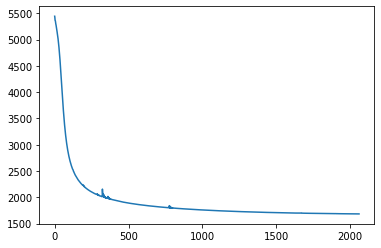

In [72]:
lr = 0.01

x = torch.tensor(x_np).float()

data_dim = 2
hidden_dim = 1

encoder = Encoder(data_dim, hidden_dim)
decoder = Decoder(hidden_dim, data_dim)

mse = nn.MSELoss()
optimizer = optim.Adam((*encoder.parameters(), *decoder.parameters()), lr=lr)

tol = 1e-3
losses = []
for _ in tqdm(iter(int, 1)):
    optimizer.zero_grad()
    z = encoder(x)
    rec = decoder(z)
    rec_loss = torch.sum((x - rec)**2) / 2
    kl_loss = (encoder.sd**2 + (encoder.mean)**2 - 2*torch.log(encoder.sd) - 1).sum() / 2
    loss = rec_loss + kl_loss
    if losses and abs(loss.item() - losses[-1]) < tol:
        break
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
plt.plot(losses[10:])
losses[-1], rec_loss.item(), kl_loss.item()

Now, we see that our model converges even without some weird tricks on KL contribution to overall loss.

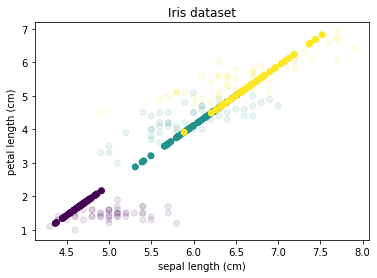

In [73]:
plt.scatter(x_np[:, 0], x_np[:, 1], c=y, alpha=0.1)
x_values = np.linspace(4,9,100)

z = encoder.deterministic_forward(x)
x_model = decoder(z).detach().numpy()
plt.scatter(x_model[:, 0], x_model[:, 1], c=y)

plt.xlabel("sepal length (cm)")
plt.ylabel("petal length (cm)")
plt.title("Iris dataset");

Now, let's generate some samples using our generative model.

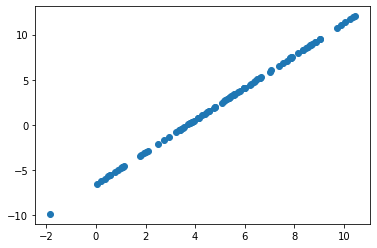

In [74]:
z_ = torch.randn((100))
x_ = decoder(z_).detach().numpy()
plt.scatter(x_[:, 0], x_[:, 1])

We see that the range of possible values makes more sense, but it is still not quite right.

---
#### Neural decoder
All right, and know the last experiment with neural deocder.

(163.1143798828125, 63.42296600341797, 99.69142150878906)

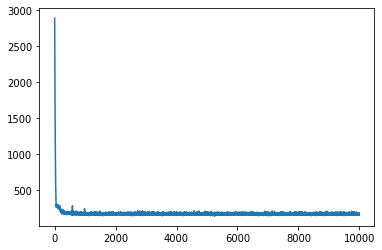

In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris


class Encoder(nn.Module):
    """
    Responsible for generating from q(z|x) distribution: gaussian with diagonal covariance matrix
    with parameters (both means and standard deviations) given by multilayer perceptron.
    """
    def __init__(self, n_in, dim):
        super().__init__()
        self.mean = None
        self.sd = None
        hidden_dim = 256
        self.encode = nn.Sequential(
            nn.Linear(n_in, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.encode_mean = nn.Linear(hidden_dim, dim)
        self.encode_sd = nn.Sequential(
            nn.Linear(hidden_dim, dim),
            nn.ReLU()
        )

    def forward(self, x):
        z = self.encode(x)
        self.mean = self.encode_mean(z)
        self.sd = self.encode_sd(z) + 0.00001
        assert self.mean.shape == self.sd.shape
        return self.mean + self.sd * torch.randn_like(self.sd)
    
    def deterministic_forward(self, x):
        z = self.encode(x)
        return self.encode_mean(z)


class Decoder(nn.Module):
    def __init__(self, dim, n_out):
        super().__init__()
        sd = 0.01
        hidden_dim = 20
        self.decode = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_out)
        )
        

    def forward(self, z):
        x = self.decode(z)
        return x
    
encoder = Encoder(2, 1)
decoder = Decoder(1, 2)

lr = 0.01

x = torch.tensor(x_np).float()

data_dim = 2
hidden_dim = 1

encoder = Encoder(data_dim, hidden_dim)
decoder = Decoder(hidden_dim, data_dim)

mse = nn.MSELoss()
optimizer = optim.Adam((*encoder.parameters(), *decoder.parameters()), lr=lr)

tol = 8e-4
losses = []

for _ in trange(10_000):
    optimizer.zero_grad()
    z = encoder(x)
    rec = decoder(z)
    rec_loss = torch.sum((x - rec)**2) / 2
    kl_loss = (encoder.sd**2 + (encoder.mean)**2 - 2*torch.log(encoder.sd) - 1).sum() / 2
    loss = rec_loss + kl_loss
    if losses and abs(loss.item() - losses[-1]) < tol:
        break
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
plt.plot(losses[10:])
losses[-1], rec_loss.item(), kl_loss.item()

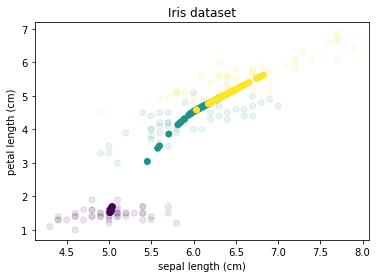

In [84]:
plt.scatter(x_np[:, 0], x_np[:, 1], c=y, alpha=0.1)
x_values = np.linspace(4,9,100)

z = encoder.deterministic_forward(x)
x_model = decoder(z).detach().numpy()
plt.scatter(x_model[:, 0], x_model[:, 1], c=y)

plt.xlabel("sepal length (cm)")
plt.ylabel("petal length (cm)")
plt.title("Iris dataset");

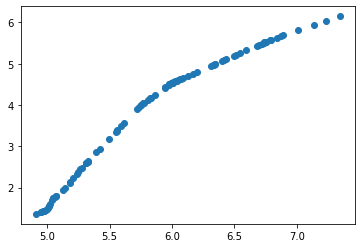

In [88]:
z_ = torch.randn((100, 1))
x_ = decoder(z_).detach().numpy()
plt.scatter(x_[:, 0], x_[:, 1])

Here is how $z$ values look like for consecutive observations. First class has higher values, while third the lowest.

Text(0.5, 0, 'observation number')

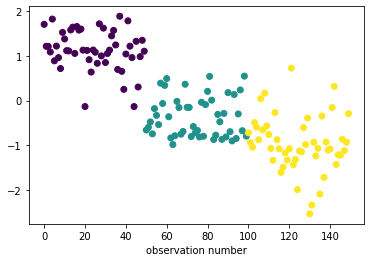

In [103]:
z = encoder(x).detach().numpy()
plt.scatter(np.arange(len(z)) ,z, c=y)
plt.xlabel("observation number");